# Word Frequency Model
Ryan Henderson

This is my first pass at the Spectrm challenge, using the simplest model I could think of: word frequency in the dialogs vs. the missing responses.  While this should be considered a baseline, I was nevertheless able to get recall rates around 6-8%.

### Prepare the data:

In [1]:
%matplotlib inline
from spectrm_challenge_ryan.helpers import SpectrmLoader
from spectrm_challenge_ryan.models import WordFrequency
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

`SpectrmLoader` and `WordFrequency` are custom classes in this module.  They are just abstracting away the logic of reading the Spectrm-formatted data and doing some word counting in the different dialogs, respectively.

In [2]:
# load the data
loader = SpectrmLoader()
data = loader.load()
print 'Datasets loaded: ' + str(data.keys())

Datasets loaded: ['test_dialogs', 'train_missing', 'train_dialogs', 'test_missing']


`wf_corpus` will hold information about word frequencies across the whole training corpus

In [3]:
wf_corpus = WordFrequency()

In [4]:
# Specify the number of training dialogs we want to use, and how many to hold out for testing
n_training_dialogs = 9000
n_test_dialogs = 3000

# specify which labels to use
labels = data['train_dialogs'].index.unique()[:n_training_dialogs]
# compute word frequencies in the training set
wf_corpus.get_unique_non_stop_words(data['train_dialogs'].ix[labels])
# specify test labels
labels_test = data['train_dialogs'].index.unique()[n_training_dialogs:n_training_dialogs + n_test_dialogs]

`labels` are the given dialog labels

In [5]:
print labels[:10]

['c09122' 'c23477' 'c22408' 'c21573' 'c04501' 'c20909' 'c03253' 'c25164'
 'c21814' 'c20479']


In [6]:
data['train_dialogs'].ix['c09122']

,text
id,
c09122,I know how to get outside the shield.
c09122,Where do we come in?
c09122,Getting outside the shield is easy. After that...
c09122,Possibly.
c09122,Candidate for what?


In [7]:
data['train_missing'].ix['c09122']

text    I can't make it alone. You're the likeliest ca...
Name: c09122, dtype: object

`wf_corpus.counts` tells us about the raw frequencies

In [8]:
print wf_corpus.counts[:10]

you     25699
i       24734
the     16307
to      13631
a       12206
it      10952
s       10876
t        9564
and      8049
that     7984
dtype: int64


`unique_non_stop_words` is a collection of all the unique words not considered "stopwords"

In [9]:
print wf_corpus.unique_non_stop_words[610:620]

11767     airborne
11697     aircraft
18558     airfield
2485       airline
14636     airlines
3773      airplane
7633     airplanes
1970       airport
11490     airports
20588         airs
dtype: object


In [10]:
print 'Number of examples: ' + str(len(labels))
print 'Number of words in training corpus: ' + str(len(wf_corpus.unique_non_stop_words))

Number of examples: 9000
Number of words in training corpus: 21622


## Generate the model
Here we get to the "training."  Training in quotation marks because there is no actual machine learning done -- we'll handmake the weights based on the prior probability of encountering a word in the corpus.

Let's generate our input vectors.  For a first pass, we'll work in a large-dimensional space -- as many dimensions as there are unique non-stopwords in the corpus.  Then for each dialog, we'll put a `1` in the vector if the word appears in the dialog, `0` otherwise.

In [11]:
# dicts to hold our representation, one for the training dialogs, and one for this missing lines
input_mat = {}
target_mat = {}
# we'll calculate frequencies separately
wf_input = WordFrequency()
wf_target = WordFrequency()
# counter variable
cnt = 0
for label in labels:
    # get all the unique stopwords for training and missing
    wf_input.get_unique_non_stop_words(data['train_dialogs'].ix[label])
    wf_target.get_unique_non_stop_words(data['train_missing'].ix[label].text)
    # generate appropriate vectors, including normalization
    input_mat[label] = wf_corpus.unique_non_stop_words.isin(wf_input.unique_non_stop_words)
    input_mat[label].index = wf_corpus.unique_non_stop_words.values
    norm = np.linalg.norm(input_mat[label])
    if norm > 0.0:
        input_mat[label] = input_mat[label]/norm
    target_mat[label] = wf_corpus.unique_non_stop_words.isin(wf_target.unique_non_stop_words)
    target_mat[label].index = wf_corpus.unique_non_stop_words.values
    norm = np.linalg.norm(target_mat[label])
    if norm > 0.0:
        target_mat[label] = target_mat[label]/norm
    cnt += 1
    if cnt % 1000 == 0:
        print 'Records processed: ' + str(cnt)


Records processed: 1000
Records processed: 2000
Records processed: 3000
Records processed: 4000
Records processed: 5000
Records processed: 6000
Records processed: 7000
Records processed: 8000
Records processed: 9000


Make the input and target matrices:

In [12]:
train_dialog_vectors = pd.DataFrame(input_mat).T.astype('float')
train_dialog_vectors.shape

(9000, 21622)

In [13]:
train_missing_vectors = pd.DataFrame(target_mat).T.astype('float')
train_missing_vectors.shape

(9000, 21622)

The resulting matrices are _very_ sparse -- this model as implemented is rather memory-inefficient

In [14]:
train_dialog_vectors

,0,00,000,007,03,05,06,065,0800,0821,...,zot,zowie,zozo,zt,zu,zulu,zurich,zus,zuzu,zydowski
c00010,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c00018,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c00019,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c00022,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c00023,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c00024,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c00025,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c00026,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c00030,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c00034,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# delete to save memory
del(input_mat)
del(target_mat)

## Evaluation
Now we can see how we did, and make some tweaks.  First, I calculate a matrix `t_raw`, which is the dot product of the `training_dialog_vectors` and the `train_missing_vectors`.  Thus we get a score for every dialog against every missing line.

In [16]:
t_raw = np.dot(train_dialog_vectors.values, train_missing_vectors.values.T)

Before going on, let's define a few functions that will be helpful in scoring:

In [17]:
def softmax(x):
    """
    Softmax normalizes a vector into a probability distribution.
    After applying the softmax, the vectors sums to unity.
    """
    sf = np.exp(x)
    sf = sf/np.sum(sf, axis=0)
    return sf

def cross_entropy(y_predicted_matrix):
    """
    Cross entropy is a measure of how different two distributions
    are.  In our case, the difference between a row in t_raw, and an
    identity matrix representing perfect classification.
    
    Lower values are better.
    """
    return -np.sum(np.diag(np.log(y_predicted_matrix)))

def recall(confusion_matrix):
    """
    Recall is a measure of model performance given by the number of
    true positives divided by the sum of true positives and false
    negatives.
    
    Higher values are better.
    """
    tp = sum(np.argmax(confusion_matrix,axis=0) == range(confusion_matrix.shape[0]))
    return tp/float(t_raw.shape[0])

First, apply the softmax:

In [18]:
t_raw = np.apply_along_axis(softmax, 0, t_raw)

Let's look at a heatmap of a portion of `t_raw`.  The diagonal band is encouraging -- some dialogs are matching their missing responses!  But the plot is really noisy. The vertical/horizontal bands indicate some words are dominating.  We'll do something about that in a minute.

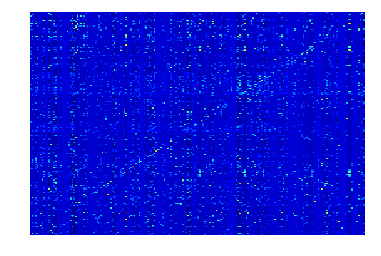

In [19]:
plt.axis('off')
heatmap = plt.pcolor(t_raw[:200,:200])

In [20]:
print 'Recall: ' + str(recall(t_raw))
print 'Cross-entropy loss: ' + str(cross_entropy(t_raw))

Recall: 0.0427777777778
Cross-entropy loss: 81287.752928


### Adding weights
Some words appear in many responses and distract our model.  We should penalize words that are common anyway, so that unique words connecting dialogs and responses are more prominent.  We do that by constructing a weight matrix, `W`:

In [21]:
W = np.diag(1./wf_corpus.counts[train_dialog_vectors.columns])

In [22]:
t_weighted = np.dot(np.dot(train_dialog_vectors.values, W), train_missing_vectors.values.T)
t_weighted = np.apply_along_axis(softmax, 0, t_weighted)

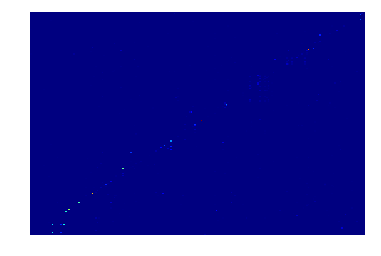

In [23]:
plt.axis('off')
heatmap = plt.pcolor(t_weighted[:200,:200])

Now the plot looks much cleaner.  The non-unique words are suppressed.  The recall rate has improved modestly, but the cross-entropy loss remains more or less the same.

In [24]:
tp = sum(np.argmax(t_weighted,axis=0) == range(t_weighted.shape[0]))
print 'Recall: ' + str(tp/float(t_weighted.shape[0]))
print 'Cross-entropy loss: ' + str(cross_entropy(t_weighted))

Recall: 0.0675555555556
Cross-entropy loss: 81887.5798139


### Test data
Let's see if this model generalizes to some of the conversations it didn't build a corpus from.  This is the same loop as above, but iterating over `labels_test` instead of `labels`. We use the same words, so the vectors will have the same length.

In [25]:
input_mat = {}
target_mat = {}
wf_input = WordFrequency()
wf_target = WordFrequency()
cnt = 0
for label in labels_test:
    # get all the unique stopwords for training and missing
    wf_input.get_unique_non_stop_words(data['train_dialogs'].ix[label])
    wf_target.get_unique_non_stop_words(data['train_missing'].ix[label].text)
    # generate appropriate vectors, including normalization
    input_mat[label] = wf_corpus.unique_non_stop_words.isin(wf_input.unique_non_stop_words)
    input_mat[label].index = wf_corpus.unique_non_stop_words.values
    norm = np.linalg.norm(input_mat[label])
    if norm > 0.0:
        input_mat[label] = input_mat[label]/norm
    target_mat[label] = wf_corpus.unique_non_stop_words.isin(wf_target.unique_non_stop_words)
    target_mat[label].index = wf_corpus.unique_non_stop_words.values
    norm = np.linalg.norm(target_mat[label])
    if norm > 0.0:
        target_mat[label] = target_mat[label]/norm
    cnt += 1
    if cnt % 1000 == 0:
        print 'Records processed: ' + str(cnt)

Records processed: 1000
Records processed: 2000
Records processed: 3000


In [26]:
test_dialog_vectors = pd.DataFrame(input_mat).T.astype('float')
test_dialog_vectors.shape

(3000, 21622)

In [27]:
test_missing_vectors = pd.DataFrame(target_mat).T.astype('float')
test_missing_vectors.shape

(3000, 21622)

In [28]:
del(input_mat)
del(target_mat)

In [29]:
test_weighted = np.dot(np.dot(test_dialog_vectors.values, W), test_missing_vectors.values.T)
test_weighted = np.apply_along_axis(softmax, 0, test_weighted)

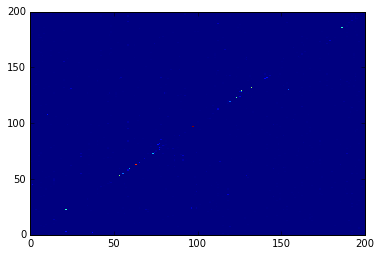

In [30]:
heatmap = plt.pcolor(test_weighted[:200,:200])

We can clearly see the model is still robust against new samples -- suspiciously so.  Maybe some of these dialogs come from the same movies (or I made a mistake somewhere!).  There could also be some order to the dialogs, in which case I should shuffle them beforehand.  The huge drop in cross-entropy loss is particularly interesting.

In [31]:
tp = sum(np.argmax(test_weighted,axis=0) == range(test_weighted.shape[0]))
print 'Recall: ' + str(tp/float(test_weighted.shape[0]))
print 'Cross-entropy loss: ' + str(cross_entropy(test_weighted))

Recall: 0.08
Cross-entropy loss: 24003.2519577


## Questions

I hope questions 1 & 2 are covered above.  I chose recall and cross-entropy loss for evaluation because of the high number of classes.

The most glaring weakness of this approach is that if the missing dialog has no distinguishing words, this approach has no hope of matching it.  Even if you accept that, the only way to improve the model is too add more words to the corpus, since no true learning is done.  Using dense matrices to represent these weights and vectors is also extremely inefficient.

In practice, this should be used as an input to a more sophisticated model.  Inspired by the Danescu-Niculescu-Mizil and Lee paper, I really wanted to tokenize all the inputs into parts of speech and train a small neural net to learn the weights of each of these frequencies (e.g. percent adverbs, percent nouns etc).  The evaluation of model presented in this notebook could serve as one of the inputs to the NN.